# Setup Framework

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

!cp /content/drive/MyDrive/'Colab Notebooks'/Assignment1/Images.zip . # /content/drive/MyDrive/Colab Notebooks/Assignment1/Images.zip
!unzip -q -o Images.zip
!rm Images.zip

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import pathlib
import shutil
import tempfile
import math 
import datetime
import time

from tensorflow import keras
print(tf.__version__)

2.7.0


# Import Data

In [3]:
train = pd.read_csv('./Images/S40AR_train_data.csv') # /content/drive/MyDrive/Colab Notebooks/Assignment1/S40AR_train_data.csv
test = pd.read_csv('./Images/S40AR_test_data.csv') # /content/drive/MyDrive/Colab Notebooks/Assignment1/S40AR_test_data.csv

train.head()

FileName           action             action_class
0  Img_1000.jpg  walking_the_dog  Interacting_with_animal
1  Img_1001.jpg    riding_a_bike           other_activity
2  Img_1002.jpg        gardening            domestic_work
3  Img_1008.jpg          cooking            domestic_work
4  Img_1010.jpg          jumping           other_activity

In [ ]:
train.shape, test.shape

((3030, 3), (2100, 1))

In [ ]:
3030+2100

5130

# Data Pre-processing

In [5]:
act_label = {0: 'cleaning_the_floor', 1: 'climbing', 2: 'cooking',
            3: 'cutting_vegetables', 4: 'feeding_a_horse', 5: 'gardening', 6: 'jumping',
            7: 'phoning', 8: 'playing_guitar', 9: 'playing_violin', 10: 'riding_a_bike',
            11: 'riding_a_horse', 12: 'rowing_a_boat', 13: 'running', 14: 'shooting_an_arrow',
            15: 'taking_photos', 16: 'texting_message', 17: 'using_a_computer',
            18: 'walking_the_dog', 19: 'washing_dishes', 20: 'watching_TV'}

act_class_label = {0: 'Interacting_with_animal', 1 : 'domestic_work', 2: 'other_activity',
                   3: 'playing_musical_instrument', 4: 'using_comm_device'}

lab_act = {v: k for k, v in act_label.items()}
lab_act_class = {v: k for k, v in act_class_label.items()}

train['act_num'] = train['action'].map(lab_act)
train['act_class_num'] = train['action_class'].map(lab_act_class)
train.head()

FileName           action  ... act_num  act_class_num
0  Img_1000.jpg  walking_the_dog  ...      18              0
1  Img_1001.jpg    riding_a_bike  ...      10              2
2  Img_1002.jpg        gardening  ...       5              1
3  Img_1008.jpg          cooking  ...       2              1
4  Img_1010.jpg          jumping  ...       6              2

[5 rows x 5 columns]

In [16]:
unique_df = train[['action', 'action_class']]

print('***Action***')
for a in unique_df['action'].unique():
  print(a)

print('\n***Action Class***')
for a in unique_df['action_class'].unique():
  print(a)

***Action***
walking_the_dog
riding_a_bike
gardening
cooking
jumping
cutting_vegetables
watching_TV
cleaning_the_floor
shooting_an_arrow
texting_message
playing_violin
feeding_a_horse
taking_photos
washing_dishes
riding_a_horse
rowing_a_boat
playing_guitar
climbing
running
phoning
using_a_computer

***Action Class***
Interacting_with_animal
other_activity
domestic_work
using_comm_device
playing_musical_instrument


Plot some data

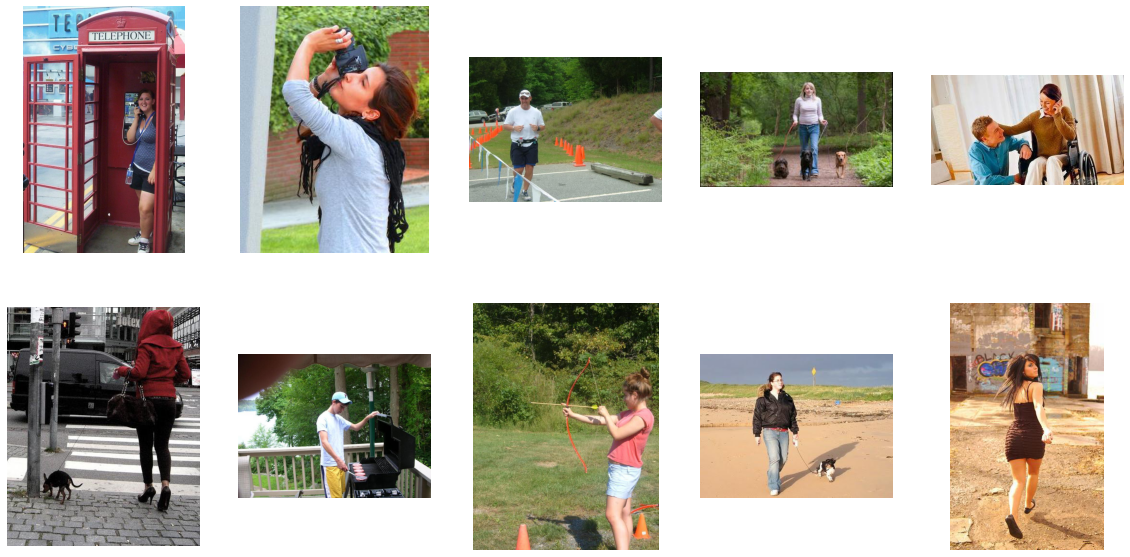

In [26]:
from scipy.ndimage import shift
import IPython.display as display
from PIL import Image

rand_data = train.sample(n = 10, replace=True, random_state=1)

plt.figure(figsize=(20,10))

prefix = './Images/Images/'

i = 0
for inx, row in rand_data.iterrows():
    im = Image.open(prefix + row['FileName'])
    im = np.asarray(im)
    plt.subplot(2,5,i+1)
    plt.imshow(im)
    plt.axis('off')
    i = i+1
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# splitting the data into train and test
train_df, test_df = train_test_split(train, test_size=0.2, random_state=0)

# further splitting the train_df to train and validation set
train_set, val_set = train_test_split(train_df, test_size=0.2, random_state=0)

print("Training Shape: ",train_set.shape)
print("Validation Shape: ",val_set.shape)
print("Testing Shape: ",test_df.shape)

Training Shape:  (1939, 5)
Validation Shape:  (485, 5)
Testing Shape:  (606, 5)


# Image DataGenerator

In [ ]:
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift, affine_transform
from PIL import Image

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=32, dim=(224, 224, 3), n_action=21, n_class=5, data_mean=0, data_std=1,  data_prefix='', shuffle=True, Augment=True):
        'Initialization'
        self.dim = dim  # Dimentions of the input
        self.batch_size = batch_size
        self.n_action = n_action  # Number of actions
        self.n_class = n_class # Number of actions_classes
        self.shuffle = shuffle  # Flag to shuffle data at the end of epoch
        self.Augment = Augment  # Flag to augment the data

        # The data is input as a pandas dataframe, we need to read the relevent fields
        self.data_frame = data_frame
        self.image_label = data_frame[['act_num', 'act_class_num']].values.tolist()
        self.image_ids = np.arange(len(self.image_label)).tolist()
        self.data_prefix = data_prefix
        
        # Data normalization parameters
        self.data_mean = data_mean
        self.data_std = data_std
        
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data for the given index'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        data_ids_temp = [self.image_ids[k] for k in indexes]
        image_label_act = [self.image_label[k][0] for k in indexes]
        image_label_class = [self.image_label[k][1] for k in indexes]

        # Generate data
        X, y, y_class = self.__data_generation(data_ids_temp, image_label_act, image_label_class)
        
        return X, {'y_action': y, 'y_action_class': y_class}

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
         
    # Support function
    def __data_generation(self, data_ids_temp, image_label_act, image_label_class):
        'Generates data containing batch_size samples' 

        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)
        y_class = np.empty((self.batch_size), dtype=int)
        
        # Generate data
        for i, ids in enumerate(data_ids_temp):
            
            X[i,] = self.__read_data_instance(data_ids_temp[i])
            y[i] = image_label_act[i]
            y_class[i] = image_label_class[i]

        return X, keras.utils.to_categorical(y, num_classes=self.n_action), keras.utils.to_categorical(y_class, num_classes=self.n_class)

    def __read_data_instance(self, pid):
      # Read an image
      filepath = self.data_prefix + self.data_frame.iloc[pid]['FileName']
      
      data = Image.open(filepath)
      data = data.resize((224,224))
      data = np.asarray(data)
      # print(data)
      # data = np.expand_dims(data, axis = 0) # expanding channels control the channels
      
      if self.Augment:
          rot = np.random.rand(1) < 0.7
          if rot:
              rot = np.random.randint(-15,15, size=1)
              data = rotate(data, angle=rot[0], reshape=False)

          shift_val = np.random.randint(-15, high=15, size=2, dtype=int).tolist() + [0,]
          data = shift(data, shift_val, order=0, mode='constant', cval=0.0, prefilter=False)
          data = np.expand_dims(data, axis=0)

      X = data

      # Input normalization
      X = (X - self.data_mean)/self.data_std
      return X

In [ ]:
prefix = './Images/Images/'

# non-augmented data
no_aug_training_generator = DataGenerator(train_set, batch_size=32, data_mean=0., 
                                   data_std=255., n_action=21, n_class=5, 
                                   Augment=False, data_prefix=prefix)

# augmented training data
training_generator = DataGenerator(train_set, batch_size=32, data_mean=0., 
                                   data_std=255., n_action=21, n_class=5, 
                                   Augment=True, data_prefix=prefix)

# non-augmented validation data
validation_generator = DataGenerator(val_set, batch_size=32, data_mean=0., 
                                     data_std=255., n_action=21, n_class=5, 
                                     Augment=False, data_prefix=prefix)

# non-augmented test data
testing_generator = DataGenerator(test_df, batch_size=32, data_mean=0., 
                                  data_std=255., n_action=21, n_class=5, 
                                  Augment=False, data_prefix=prefix)

In [ ]:
print(training_generator.__len__())
for x, y in training_generator.__iter__():
  print(x.shape, np.array(y['y_action']).shape, np.array(y['y_action_class']).shape)

60
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3) (32, 21) (32, 5)
(32, 224, 224, 3)

In [ ]:
print('Training Steps: ',len(training_generator)//32)
print('Validation Steps: ',len(validation_generator)//32)

Training Steps:  1
Validation Steps:  0


# Exploratory Data Analysis

## Action

Action: 
riding_a_horse        196
climbing              195
jumping               195
walking_the_dog       193
riding_a_bike         193
playing_guitar        189
cooking               188
feeding_a_horse       187
playing_violin        160
phoning               159
running               151
using_a_computer      130
watching_TV           123
shooting_an_arrow     114
cleaning_the_floor    112
gardening              99
taking_photos          97
texting_message        93
cutting_vegetables     89
rowing_a_boat          85
washing_dishes         82
Name: action, dtype: int64

No. of Actions:  21


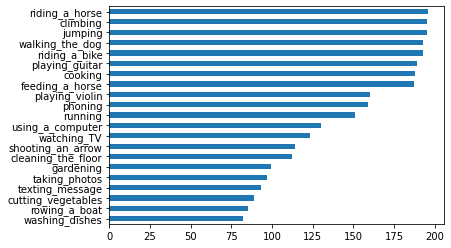

In [ ]:
print('Action: ')
print(train.action.value_counts())
print('\nNo. of Actions: ',train.action.nunique())
# action distribution
train.action.value_counts().sort_values().plot(kind = 'barh');

## Action Class


Action Class: 
other_activity                933
using_comm_device             602
Interacting_with_animal       576
domestic_work                 570
playing_musical_instrument    349
Name: action_class, dtype: int64

No. of Action Classes:  5


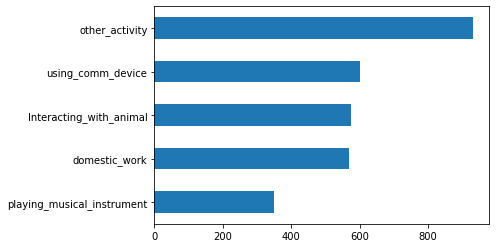

In [ ]:
print('\nAction Class: ')
print(train.action_class.value_counts())

print('\nNo. of Action Classes: ',train.action_class.nunique())

# action class distribution
train.action_class.value_counts().sort_values().plot(kind = 'barh');

## Original Images

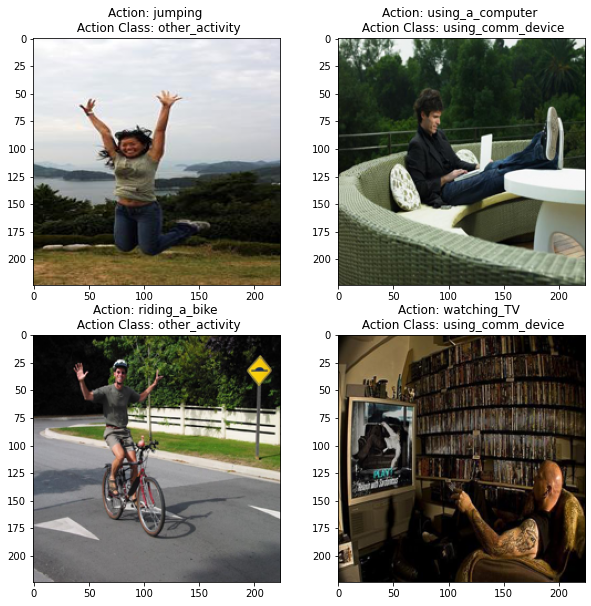

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 12):
  plt.subplot(2, 2, i+1)
  for x, y in no_aug_training_generator:
    plt.imshow(x[i])
    plt.title('Action: {} \n Action Class: {}'.format(str(act_label[np.argmax(y['y_action'][i])]),
                                                      str(act_class_label[np.argmax(y['y_action_class'][i])])))
    break
plt.tight_layout()
plt.show()

## Augmented Images

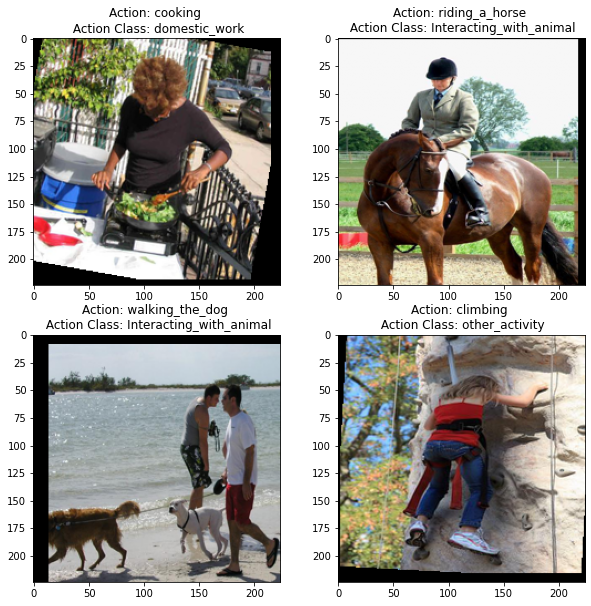

In [ ]:
plt.figure(figsize=(10,10))
for i in range(0, 12):
  plt.subplot(2, 2, i+1)
  for x, y in training_generator:
    plt.imshow(x[i])
    plt.title('Action: {} \n Action Class: {}'.format(str(act_label[np.argmax(y['y_action'][i])]),
                                                      str(act_class_label[np.argmax(y['y_action_class'][i])])))
    break
plt.tight_layout()
plt.show()

# Model Building

## Helper Functions

- Evaluation metric **F-Beta Score** to deal with class imbalance of the `Action Class`
- Plot Function for learning curves and accuracy score
- Plot Function for Total Losses

In [ ]:
from sklearn.metrics import fbeta_score
from keras import backend as bc

# Evaluation Metric for multi-label classification
def Fbeta(y_true, y_pred, beta = 2):

  # calculate fbeta, averaged across each class
	b_sq = beta ** 2

	# calculating predictions between 0 and 1
	y_pred = bc.clip(y_pred, 0, 1)
 
	# calculating true_p, false_p, false_n
	true_p = bc.sum(bc.round(bc.clip(y_true * y_pred, 0, 1)), axis=1)
	false_p = bc.sum(bc.round(bc.clip(y_pred - y_true, 0, 1)), axis=1)
	false_n = bc.sum(bc.round(bc.clip(y_true - y_pred, 0, 1)), axis=1)
 
	# calculate precision
	prec = true_p / (true_p + false_p + bc.epsilon())
 
	# calculate recall
	rec = true_p / (true_p + false_n + bc.epsilon())
 
	score = bc.mean((1 + b_sq) * (prec * rec) / (b_sq * prec + rec + bc.epsilon()))
	return score

In [ ]:
def plot_func(hist, y_act, val_y_act, y_cls_act, val_y_cls_act, 
              y_act_loss, val_y_act_loss, y_cls_act_loss, val_y_cls_act_loss, epoch):

  # action accuracy
  act_acc = hist.history[y_act]
  val_act_acc = hist.history[val_y_act]

  # action class accuracy
  act_cls_acc = hist.history[y_cls_act]
  val_act_cls_acc = hist.history[val_y_cls_act]

  # action loss
  act_loss = hist.history[y_act_loss]
  val_act_loss = hist.history[val_y_act_loss]

  # action class loss
  act_cls_loss = hist.history[y_cls_act_loss]
  val_act_cls_loss = hist.history[val_y_cls_act_loss]

  # epoch range
  epochs_range = range(epoch)

  # plots action accuracy
  plt.figure(figsize=(12, 10))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, act_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_act_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Action Training and Validation Accuracy')

  # plots action class accuracy
  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, act_cls_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_act_cls_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Action Class Training and Validation Accuracy')

  # plots action loss
  plt.subplot(2, 2, 3)
  plt.plot(epochs_range, act_loss, label='Training Loss')
  plt.plot(epochs_range, val_act_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Action Training and Validation Loss')

  # plots action class loss
  plt.subplot(2, 2, 4)
  plt.plot(epochs_range, act_cls_loss, label='Training Loss')
  plt.plot(epochs_range, val_act_cls_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Action Class Training and Validation Loss')
  plt.show()

In [ ]:
def tot_loss(hist, train_loss, validation_loss, epoch):

  epochs_range = range(epoch)

  # action accuracy
  tot_loss = hist.history[train_loss]
  tot_val_loss = hist.history[validation_loss]

  # plots total loss
  plt.figure(figsize=(5, 5))
  plt.plot(epochs_range, tot_loss, label='Training Loss')
  plt.plot(epochs_range, tot_val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Total Training and Validation Loss')

## Simple CNN Model

- Utilizing Keras Functional API

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = keras.layers.Conv2D(32, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.Conv2D(128, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.Conv2D(256, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Conv2D(512, 3, activation="relu")(x)
x = keras.layers.Conv2D(512, 3, activation="relu")(x)
x = keras.layers.MaxPooling2D(2)(x)

x = keras.layers.Flatten()(x)

# for action predictions
x_action = keras.layers.Dropout(0.5)(x)
x_action = tf.keras.layers.Dense(1024, activation='relu')(x_action)
x_action = tf.keras.layers.Dense(1024, activation='relu')(x_action)
y = tf.keras.layers.Dense(21, activation='softmax', name = 'y_action')(x_action)

# for action_class predictions
x_class = keras.layers.Dropout(0.4)(x)
x_class = tf.keras.layers.Dense(1024, activation='relu')(x_class)
y_class = tf.keras.layers.Dense(5, activation='softmax', name = 'y_action_class')(x_class)


model_simple = tf.keras.Model(inputs = inputs, outputs = [y, y_class])
model_simple.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 110, 110, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

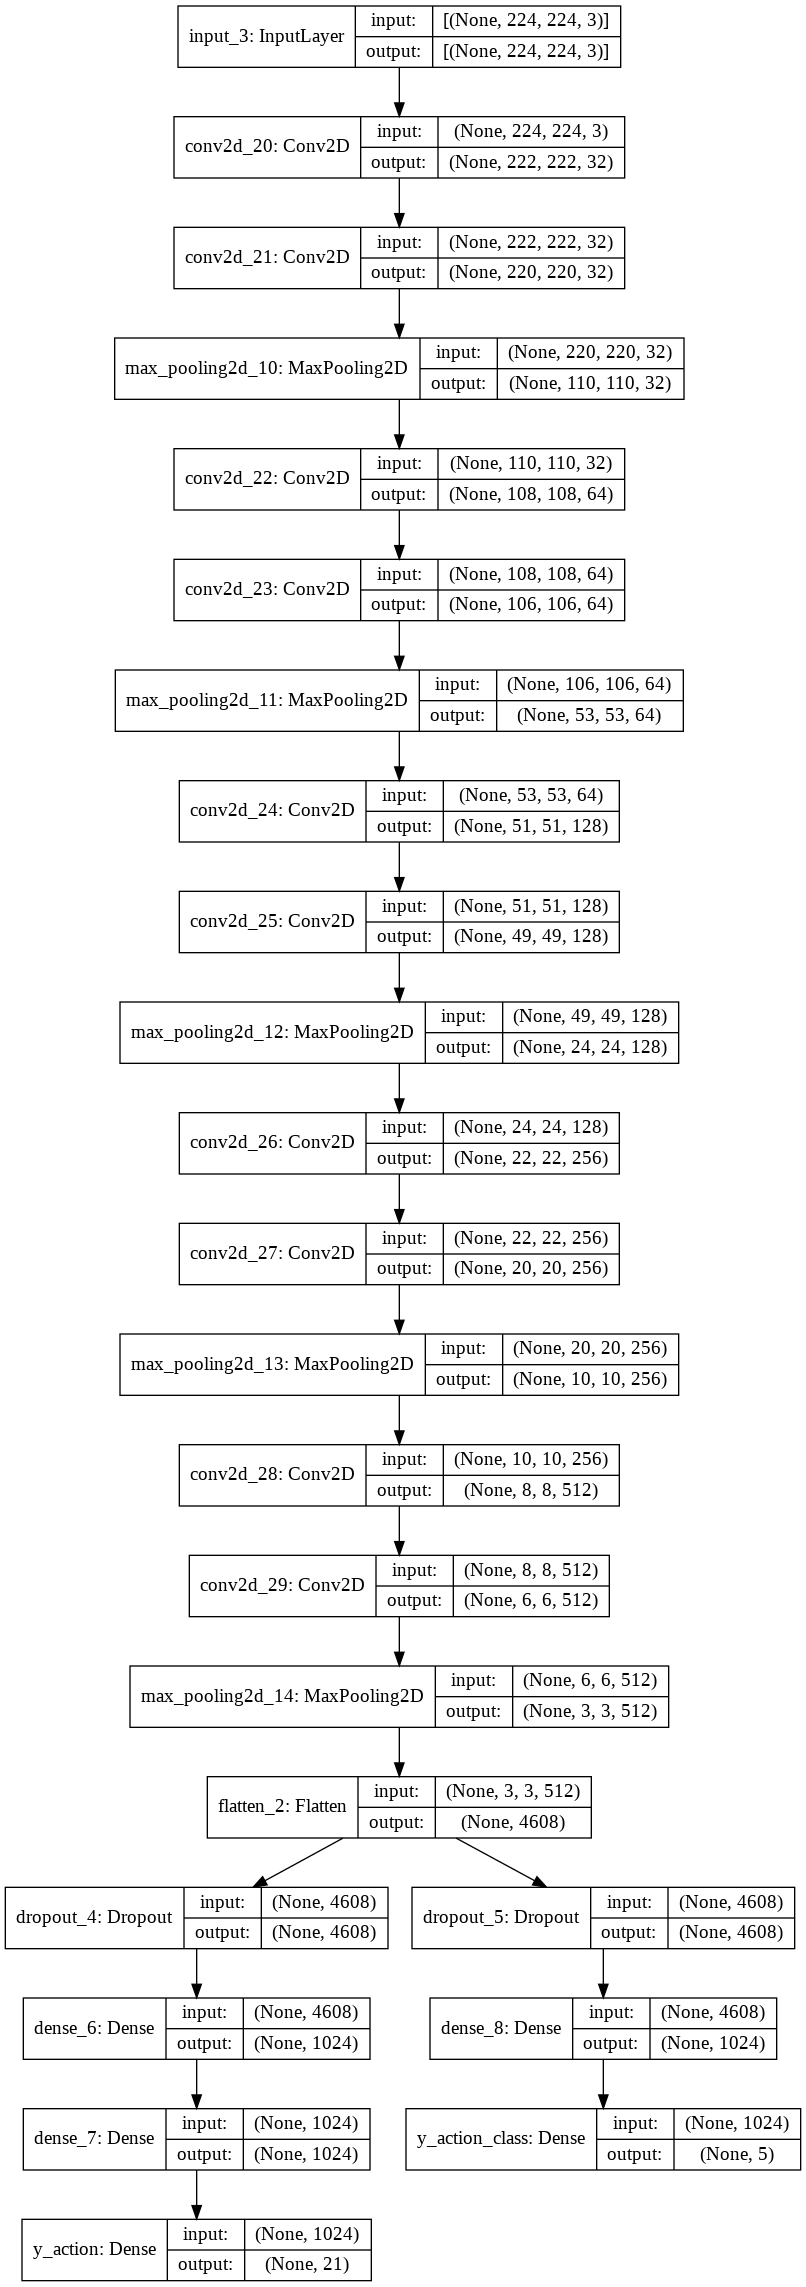

In [ ]:
tf.keras.utils.plot_model(model_simple, show_shapes=True)

In [ ]:
# compile the model
model_simple.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = {'y_action': tf.losses.CategoricalCrossentropy(), 
                      'y_action_class': tf.losses.CategoricalCrossentropy()},
              metrics = {'y_action': 'categorical_accuracy', 
                         'y_action_class': 'categorical_accuracy'})

### Original Images

In [ ]:
# fitting the model
history_simple = model_simple.fit(no_aug_training_generator,
                                  validation_data = validation_generator,
                                  epochs=100)

Epoch 1/100
60/60 [==============================] - 25s 391ms/step - loss: 4.5905 - y_action_loss: 3.0164 - y_action_class_loss: 1.5742 - y_action_categorical_accuracy: 0.0547 - y_action_class_categorical_accuracy: 0.3026 - val_loss: 4.6010 - val_y_action_loss: 3.0211 - val_y_action_class_loss: 1.5799 - val_y_action_categorical_accuracy: 0.0604 - val_y_action_class_categorical_accuracy: 0.2937
Epoch 2/100
60/60 [==============================] - 23s 381ms/step - loss: 4.5682 - y_action_loss: 3.0038 - y_action_class_loss: 1.5645 - y_action_categorical_accuracy: 0.0661 - y_action_class_categorical_accuracy: 0.3099 - val_loss: 4.6003 - val_y_action_loss: 3.0188 - val_y_action_class_loss: 1.5815 - val_y_action_categorical_accuracy: 0.0625 - val_y_action_class_categorical_accuracy: 0.2917
Epoch 3/100
60/60 [==============================] - 24s 391ms/step - loss: 4.5656 - y_action_loss: 3.0004 - y_action_class_loss: 1.5652 - y_action_categorical_accuracy: 0.0620 - y_action_class_categorica

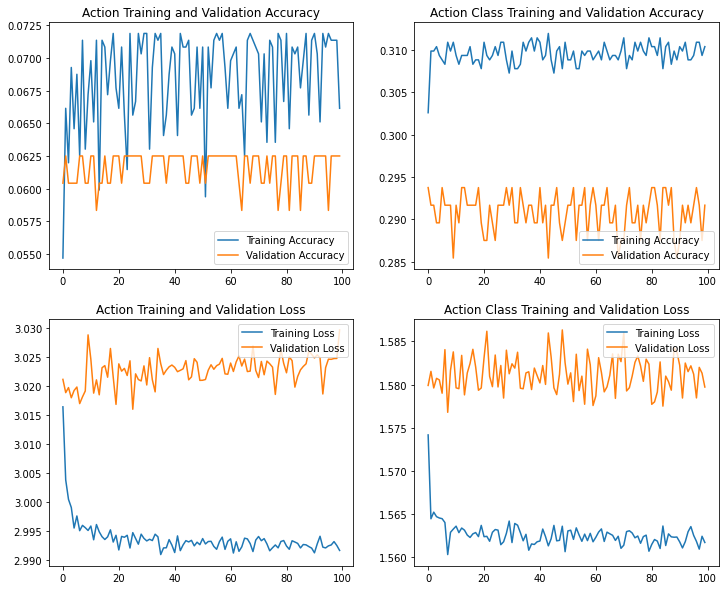

In [ ]:
plot_func(history_simple, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy', 
          'y_action_class_categorical_accuracy',
          'val_y_action_class_categorical_accuracy',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 100)

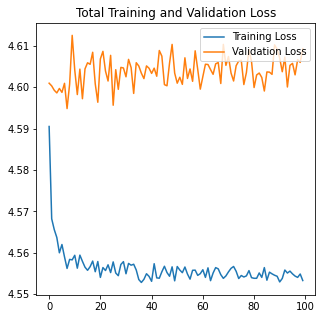

In [ ]:
tot_loss(history_simple, 'loss', 'val_loss', 100)

### Augmented Images

In [ ]:
# fitting the model
history_simple_aug = model_simple.fit(training_generator,
                                      validation_data = validation_generator,
                                      epochs=100)

Epoch 1/100
60/60 [==============================] - 56s 938ms/step - loss: 4.5540 - y_action_loss: 2.9925 - y_action_class_loss: 1.5615 - y_action_categorical_accuracy: 0.0651 - y_action_class_categorical_accuracy: 0.3104 - val_loss: 4.6045 - val_y_action_loss: 3.0236 - val_y_action_class_loss: 1.5809 - val_y_action_categorical_accuracy: 0.0604 - val_y_action_class_categorical_accuracy: 0.2917
Epoch 2/100
60/60 [==============================] - 57s 943ms/step - loss: 4.5562 - y_action_loss: 2.9935 - y_action_class_loss: 1.5627 - y_action_categorical_accuracy: 0.0708 - y_action_class_categorical_accuracy: 0.3083 - val_loss: 4.6060 - val_y_action_loss: 3.0245 - val_y_action_class_loss: 1.5815 - val_y_action_categorical_accuracy: 0.0625 - val_y_action_class_categorical_accuracy: 0.2875
Epoch 3/100
60/60 [==============================] - 55s 915ms/step - loss: 4.5542 - y_action_loss: 2.9928 - y_action_class_loss: 1.5614 - y_action_categorical_accuracy: 0.0661 - y_action_class_categorica

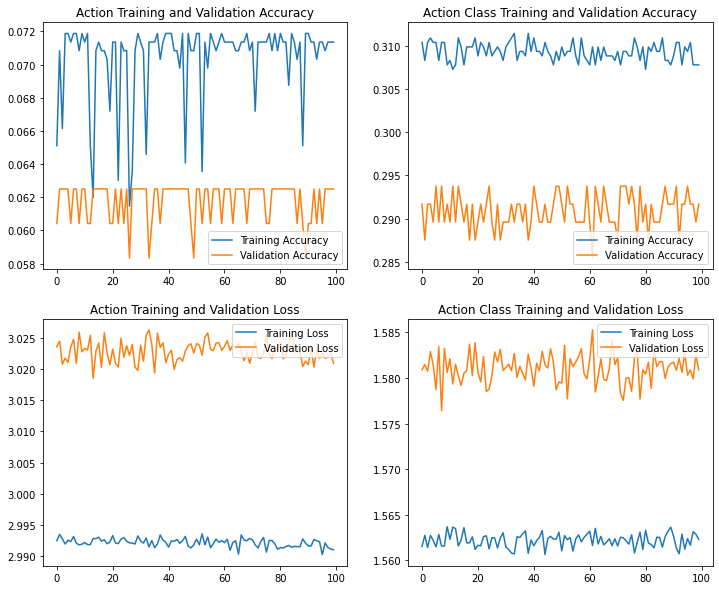

In [ ]:
plot_func(history_simple_aug, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy', 
          'y_action_class_categorical_accuracy',
          'val_y_action_class_categorical_accuracy',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 100)

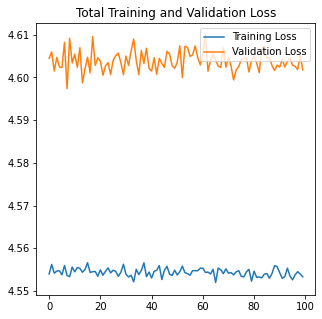

In [ ]:
# Total Loss Curves
tot_loss(history_simple_aug, 'loss', 'val_loss', 100)

After fitting both augmented and non-augmented images onto the simple model that was constructed, it is clear that the model did not produce a good generalization. Hence, Transfer Learning using pre-trained model is employed

## Transfer Learning

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.models import Model

mod_mobile = MobileNetV2()

mod_mobile.summary()

14548992/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________

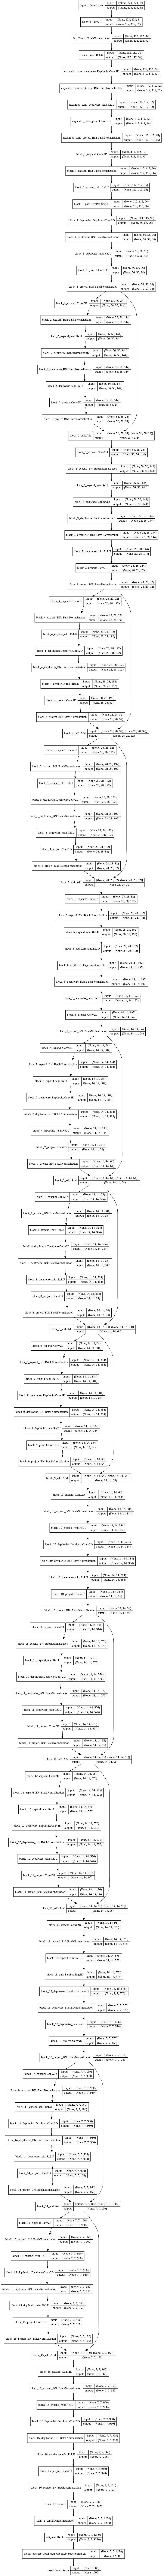

In [ ]:
# mod_mobile
tf.keras.utils.plot_model(mod_mobile, show_shapes=True)

In [ ]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# freezing the preloaded weights
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)


# for action predictions
x_action = tf.keras.layers.Dropout(0.5)(x)
x_action = tf.keras.layers.Dense(512, activation='relu')(x_action)
x_action = tf.keras.layers.Dense(512, activation='relu')(x_action)
y = tf.keras.layers.Dense(21, activation='softmax', name = 'y_action')(x_action)

# for action_class predictions
x_class = tf.keras.layers.Dropout(0.4)(x)
x_class = tf.keras.layers.Dense(512, activation='relu')(x_class)
y_class = tf.keras.layers.Dense(5, activation='softmax', name = 'y_action_class')(x_class)


model = tf.keras.Model(inputs = inputs, 
                       outputs = [y, y_class])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1280)         0           global_average_pooling2d_1[0][0] 
_______________________________

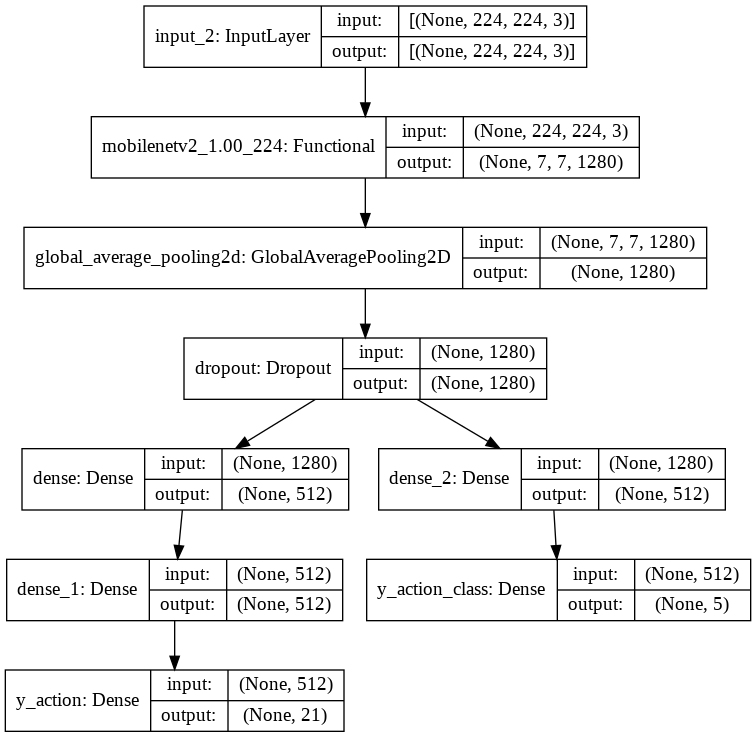

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
base_learning_rate = 0.001

# compile the model with 
# two losses and two metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = {'y_action': tf.losses.CategoricalCrossentropy(), 
                      'y_action_class': tf.losses.CategoricalCrossentropy()},
              metrics = {'y_action': 'categorical_accuracy', 
                         'y_action_class': Fbeta})

### Original Images

In [ ]:
# fitting the model
history_tf_ori = model.fit(no_aug_training_generator,
                            validation_data=validation_generator,
                            epochs=100)

Epoch 1/100
60/60 [==============================] - 24s 340ms/step - loss: 2.3576 - y_action_loss: 1.6466 - y_action_class_loss: 0.7110 - y_action_categorical_accuracy: 0.5047 - y_action_class_Fbeta: 0.7052 - val_loss: 1.2622 - val_y_action_loss: 0.7814 - val_y_action_class_loss: 0.4808 - val_y_action_categorical_accuracy: 0.7250 - val_y_action_class_Fbeta: 0.8167
Epoch 2/100
60/60 [==============================] - 19s 323ms/step - loss: 1.0647 - y_action_loss: 0.7597 - y_action_class_loss: 0.3050 - y_action_categorical_accuracy: 0.7583 - y_action_class_Fbeta: 0.8792 - val_loss: 1.0587 - val_y_action_loss: 0.6852 - val_y_action_class_loss: 0.3735 - val_y_action_categorical_accuracy: 0.7729 - val_y_action_class_Fbeta: 0.8604
Epoch 3/100
60/60 [==============================] - 19s 322ms/step - loss: 0.7820 - y_action_loss: 0.5438 - y_action_class_loss: 0.2382 - y_action_categorical_accuracy: 0.8255 - y_action_class_Fbeta: 0.9083 - val_loss: 1.1674 - val_y_action_loss: 0.7822 - val_y_a

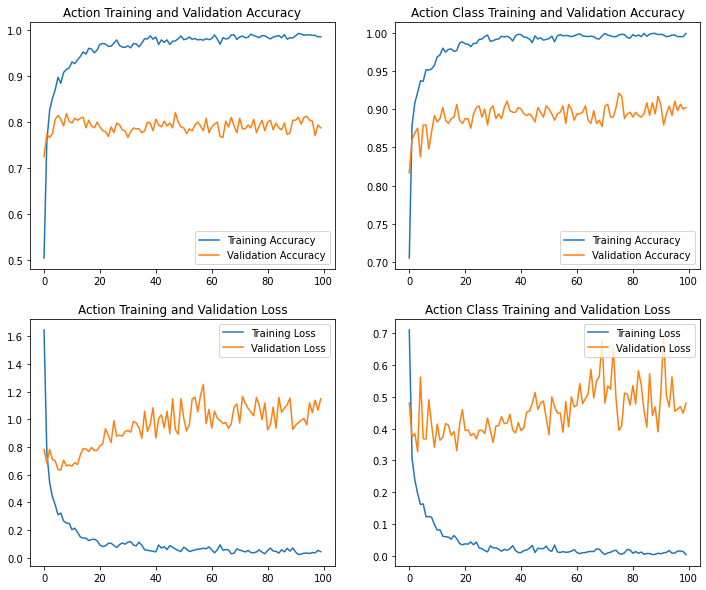

In [ ]:
plot_func(history_tf_ori, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy',
          'y_action_class_Fbeta',
          'val_y_action_class_Fbeta',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 100)

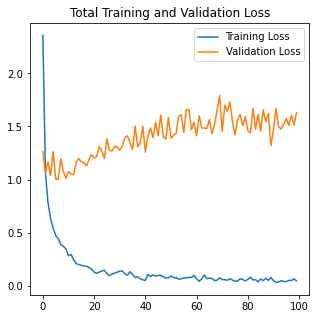

In [ ]:
# total train and validation loss
tot_loss(history_tf_ori, 'loss', 'val_loss', 100)

### Augmented Images

In [ ]:
# fitting the model
history_tf_aug = model.fit(training_generator,
                            validation_data=validation_generator,
                            epochs=100)

Epoch 1/100
60/60 [==============================] - 86s 916ms/step - loss: 2.4638 - y_action_loss: 1.7482 - y_action_class_loss: 0.7156 - y_action_categorical_accuracy: 0.4974 - y_action_class_Fbeta: 0.7146 - val_loss: 1.2866 - val_y_action_loss: 0.9029 - val_y_action_class_loss: 0.3837 - val_y_action_categorical_accuracy: 0.7208 - val_y_action_class_Fbeta: 0.8458
Epoch 2/100
60/60 [==============================] - 54s 898ms/step - loss: 1.3221 - y_action_loss: 0.9245 - y_action_class_loss: 0.3976 - y_action_categorical_accuracy: 0.7177 - y_action_class_Fbeta: 0.8510 - val_loss: 1.2269 - val_y_action_loss: 0.8630 - val_y_action_class_loss: 0.3638 - val_y_action_categorical_accuracy: 0.7125 - val_y_action_class_Fbeta: 0.8521
Epoch 3/100
60/60 [==============================] - 53s 880ms/step - loss: 1.0716 - y_action_loss: 0.7351 - y_action_class_loss: 0.3365 - y_action_categorical_accuracy: 0.7646 - y_action_class_Fbeta: 0.8625 - val_loss: 1.1298 - val_y_action_loss: 0.7213 - val_y_a

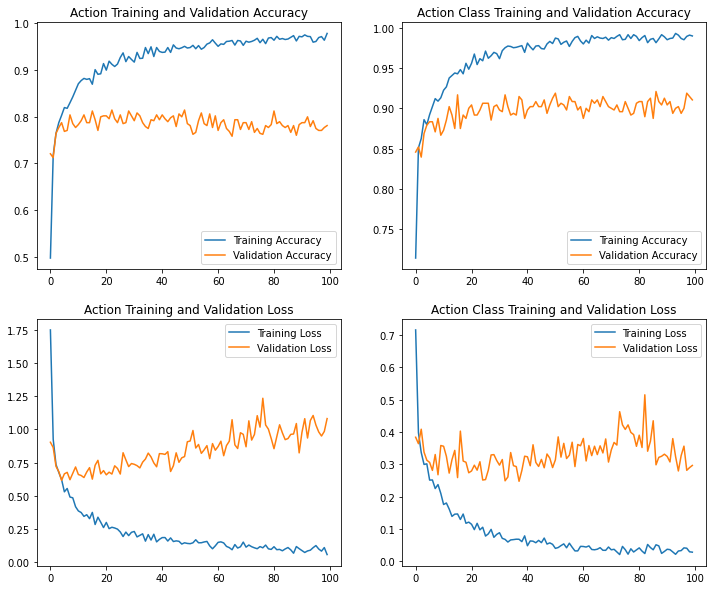

In [ ]:
plot_func(history_tf_aug, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy', 
          'y_action_class_Fbeta',
          'val_y_action_class_Fbeta',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 100)

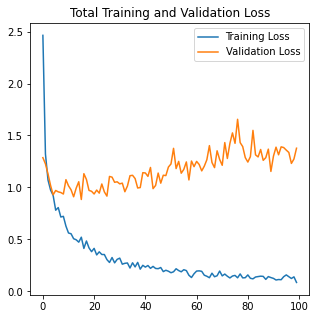

In [ ]:
# total train and validation loss
tot_loss(history_tf_aug, 'loss', 'val_loss', 100)

### Fine-Tuning

- Investigating if fine-tuning will improve the model
- Set a lower learning rate

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

print("Number of Trainable layers: ",len(model.trainable_variables))

Number of layers in the base model:  154
Number of Trainable layers:  44


In [ ]:
base_learning_rate = 0.001

# compile the model with 
# two losses and two metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss = {'y_action': tf.losses.CategoricalCrossentropy(), 
                      'y_action_class': tf.losses.CategoricalCrossentropy()},
              metrics = {'y_action': 'categorical_accuracy', 
                         'y_action_class': Fbeta})

In [ ]:
# fitting the model
history_tune_120 = model.fit(training_generator,
                            validation_data=validation_generator,
                            epochs=100)

Epoch 1/100
60/60 [==============================] - 57s 888ms/step - loss: 0.3467 - y_action_loss: 0.2112 - y_action_class_loss: 0.1355 - y_action_categorical_accuracy: 0.9344 - y_action_class_Fbeta: 0.9469 - val_loss: 1.1707 - val_y_action_loss: 0.8271 - val_y_action_class_loss: 0.3436 - val_y_action_categorical_accuracy: 0.7708 - val_y_action_class_Fbeta: 0.9000
Epoch 2/100
60/60 [==============================] - 53s 880ms/step - loss: 0.1666 - y_action_loss: 0.1128 - y_action_class_loss: 0.0537 - y_action_categorical_accuracy: 0.9651 - y_action_class_Fbeta: 0.9792 - val_loss: 1.1103 - val_y_action_loss: 0.8250 - val_y_action_class_loss: 0.2853 - val_y_action_categorical_accuracy: 0.7958 - val_y_action_class_Fbeta: 0.9229
Epoch 3/100
60/60 [==============================] - 54s 894ms/step - loss: 0.2645 - y_action_loss: 0.1678 - y_action_class_loss: 0.0967 - y_action_categorical_accuracy: 0.9417 - y_action_class_Fbeta: 0.9656 - val_loss: 1.6954 - val_y_action_loss: 1.1397 - val_y_a

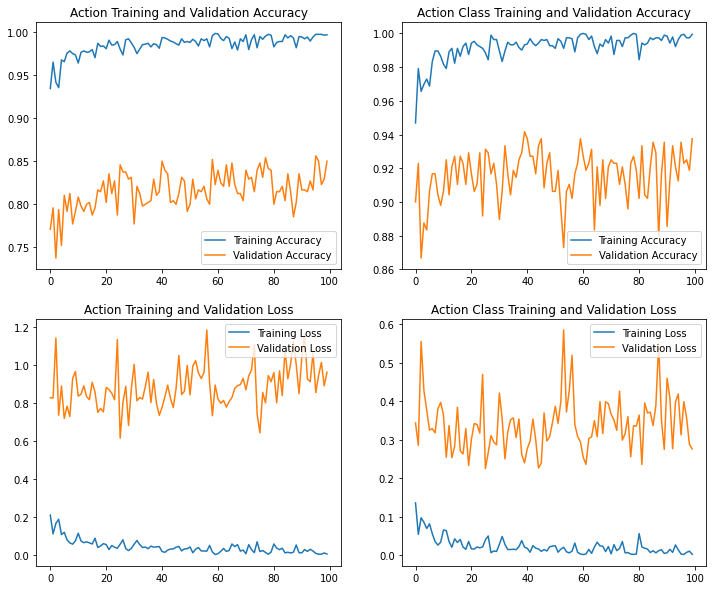

In [ ]:
plot_func(history_tune_120, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy', 
          'y_action_class_Fbeta',
          'val_y_action_class_Fbeta',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 100)

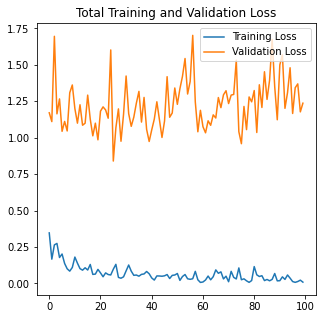

In [ ]:
tot_loss(history_tune_120, 'loss', 'val_loss', 100)

With a small training dataset, it is not suitable to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. As shown from the learning curve above, the model is not generalizing well with fine-tuning starting from the 120th layer. Therefore, the pre-trained model is kept forzen for feature extraction and only the weights of the classifier get updated during train. In this case, the convolutional base extracts all the features associated with each image and this classifer determines the action and action class given that set of extracted features. 

## Model Improvement

Improve the model to fight overfitting by:

- Dropout regularizations
- L2 regularizations
- Adding more hidden layer for the target `Action`

9420800/9406464 [==============================] - 0s 0us/step


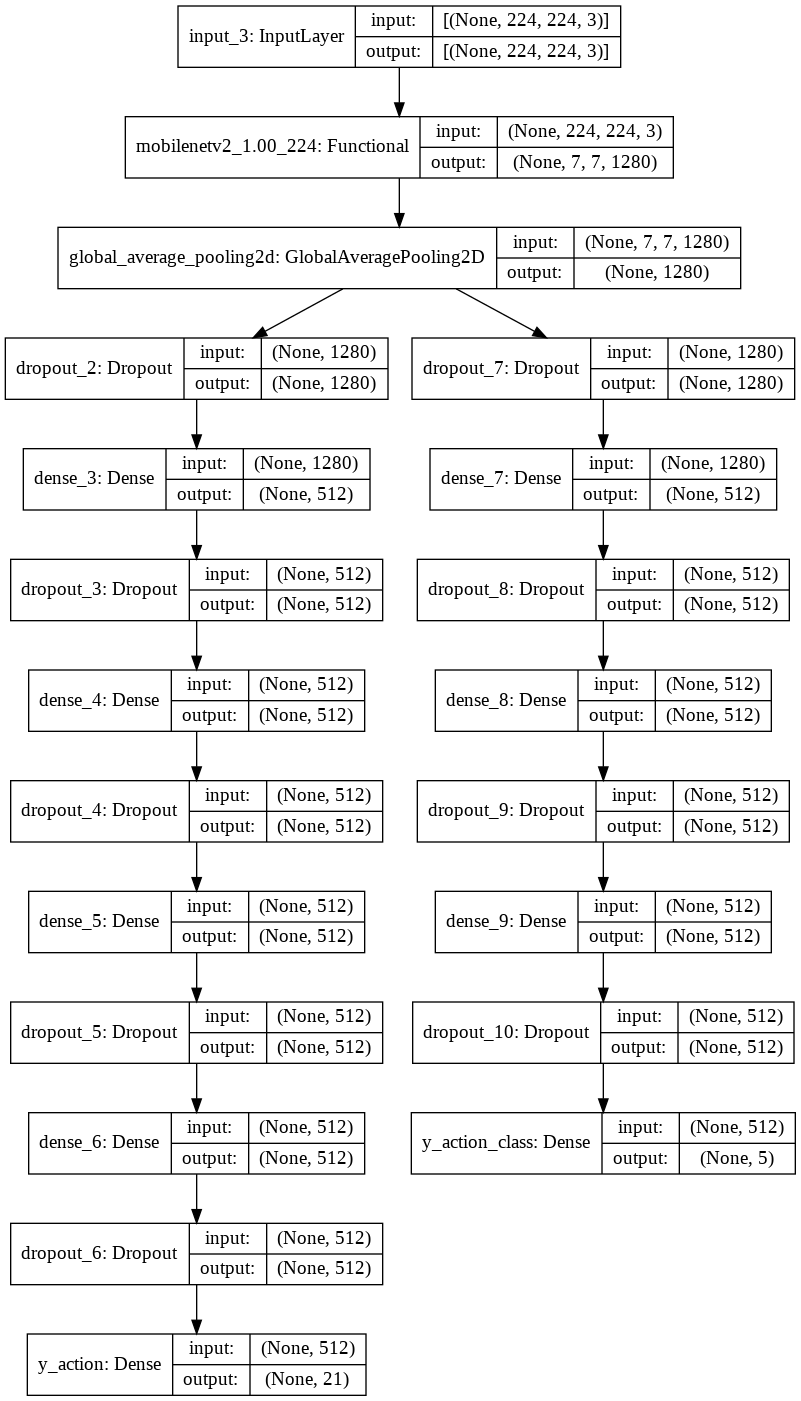

In [ ]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# freezing the preloaded weights
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# for action predictions
x_action = tf.keras.layers.Dropout(0.5)(x)
x_action = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_action)
x_action = tf.keras.layers.Dropout(0.5)(x_action)
x_action = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_action)
x_action = tf.keras.layers.Dropout(0.5)(x_action)
x_action = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_action)
x_action = tf.keras.layers.Dropout(0.5)(x_action)
x_action = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_action)
x_action = tf.keras.layers.Dropout(0.5)(x_action)
y = tf.keras.layers.Dense(21, activation='softmax', name = 'y_action')(x_action)

# for action_class predictions
x_class = tf.keras.layers.Dropout(0.4)(x)
x_class = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_class)
x_class = tf.keras.layers.Dropout(0.3)(x_class)
x_class = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_class)
x_class = tf.keras.layers.Dropout(0.3)(x_class)
x_class = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_class)
x_class = tf.keras.layers.Dropout(0.3)(x_class)
y_class = tf.keras.layers.Dense(5, activation='softmax', name = 'y_action_class')(x_class)

# model compilation
model_imp = tf.keras.Model(inputs = inputs, 
                       outputs = [y, y_class])
tf.keras.utils.plot_model(model_imp, show_shapes=True)

In [ ]:
base_learning_rate = 0.001

# compile the model with 
# two losses and two metrics
model_imp.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
                  loss = {'y_action': tf.losses.CategoricalCrossentropy(), 
                          'y_action_class': tf.losses.CategoricalCrossentropy()},
                  metrics = {'y_action': 'categorical_accuracy', 
                            'y_action_class': Fbeta})

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# simple early stopping
# val_y_action_loss
early_stop = EarlyStopping(monitor='val_y_action_loss', mode='min', patience = 20, verbose=1)

# fitting the model
history_imp = model_imp.fit(training_generator,
                            validation_data=validation_generator,
                            callbacks = [early_stop],
                            epochs=250)

Epoch 1/250
60/60 [==============================] - 85s 887ms/step - loss: 9.3031 - y_action_loss: 3.7152 - y_action_class_loss: 1.5823 - y_action_categorical_accuracy: 0.0625 - y_action_class_Fbeta: 0.1026 - val_loss: 8.1752 - val_y_action_loss: 3.0068 - val_y_action_class_loss: 1.1732 - val_y_action_categorical_accuracy: 0.1167 - val_y_action_class_Fbeta: 0.1187
Epoch 2/250
60/60 [==============================] - 54s 899ms/step - loss: 8.5282 - y_action_loss: 3.3232 - y_action_class_loss: 1.2192 - y_action_categorical_accuracy: 0.0594 - y_action_class_Fbeta: 0.2615 - val_loss: 7.8097 - val_y_action_loss: 2.9996 - val_y_action_class_loss: 0.8342 - val_y_action_categorical_accuracy: 0.1479 - val_y_action_class_Fbeta: 0.4750
Epoch 3/250
60/60 [==============================] - 54s 894ms/step - loss: 8.0485 - y_action_loss: 3.1579 - y_action_class_loss: 0.9242 - y_action_categorical_accuracy: 0.0760 - y_action_class_Fbeta: 0.4859 - val_loss: 7.5554 - val_y_action_loss: 2.9977 - val_y_a

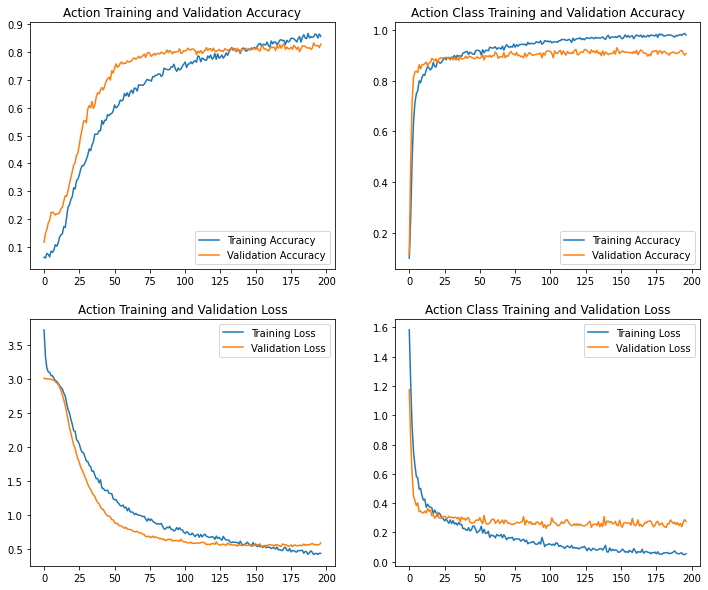

In [ ]:
plot_func(history_imp, 'y_action_categorical_accuracy',
          'val_y_action_categorical_accuracy',
          'y_action_class_Fbeta',
          'val_y_action_class_Fbeta',
          'y_action_loss', 'val_y_action_loss',
          'y_action_class_loss', 'val_y_action_class_loss', 197)

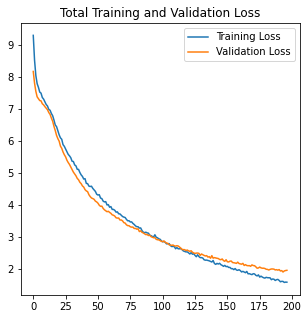

In [ ]:
# total loss curves
tot_loss(history_imp, 'loss', 'val_loss', 197)

# Model Evaluation

In [ ]:
model_imp.evaluate(test_generator)

606/606 [==============================] - 12s 20ms/step - loss: 1.9532 - y_action_loss: 0.6118 - y_action_class_loss: 0.2417 - y_action_categorical_accuracy: 0.8119 - y_action_class_Fbeta: 0.9224


[1.9531863927841187,
 0.6117903590202332,
 0.2416543811559677,
 0.8118811845779419,
 0.9224421381950378]

In [ ]:
# plot function for the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# non-augmented test data
test_generator = DataGenerator(test_df, batch_size=1, data_mean=0., 
                               data_std=255., n_action=21, n_class=5, 
                               Augment=False, data_prefix=prefix, shuffle=False)

# Constructing the confusion matrix.
from sklearn.metrics import confusion_matrix

# predictions on the unseen data
test_y_action_pred, test_y_action_class_pred = model_imp.predict(test_generator, verbose=1)

# Predicted labels
test_y_action_label = [act_label[np.argmax(i)] for i in test_y_action_pred]
test_y_action_class_label = [act_class_label[np.argmax(i)] for i in test_y_action_class_pred]

# True labels
true_action = [act_label[np.argmax(y['y_action'])] for x, y in test_generator]
true_action_class = [act_class_label[np.argmax(y['y_action_class'])] for x, y in test_generator]


print('Predicted action labels: ',len(test_y_action_label))
print('Predicted action class labels: ',len(test_y_action_class_label))
print('True action labels: ',len(true_action))
print('True action class labels: ',len(true_action_class))

606/606 [==============================] - 9s 15ms/step
Predicted action labels:  606
Predicted action class labels:  606
True action labels:  606
True action class labels:  606


## Confusion Matrix

In [ ]:
# action list
unique_action_list = []
for x in test_y_action_label:  
  if x not in unique_action_list:
      unique_action_list.append(x)
print('No. of Actions: ',len(unique_action_list))

# action class list
unique_action_class_list = []
for x in test_y_action_class_label:  
  if x not in unique_action_class_list:
      unique_action_class_list.append(x)

print('No. of Action Classes: ',len(unique_action_class_list))

No. of Actions:  21
No. of Action Classes:  5


Normalized confusion matrix


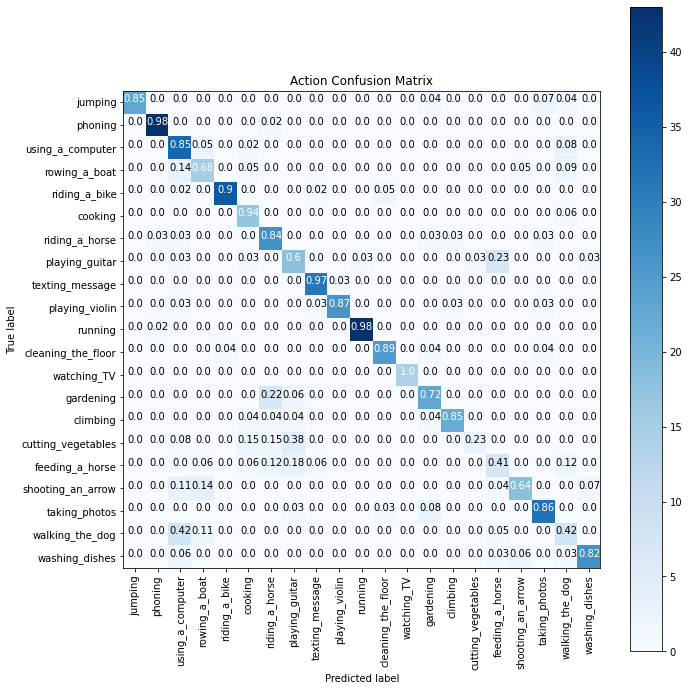

In [ ]:
cm_action = confusion_matrix(true_action, test_y_action_label)
cm_action_class = confusion_matrix(true_action_class, test_y_action_class_label)

# plot confusion matrix for Action
plot_confusion_matrix(cm_action, unique_action_list, title='Action Confusion Matrix')

Normalized confusion matrix


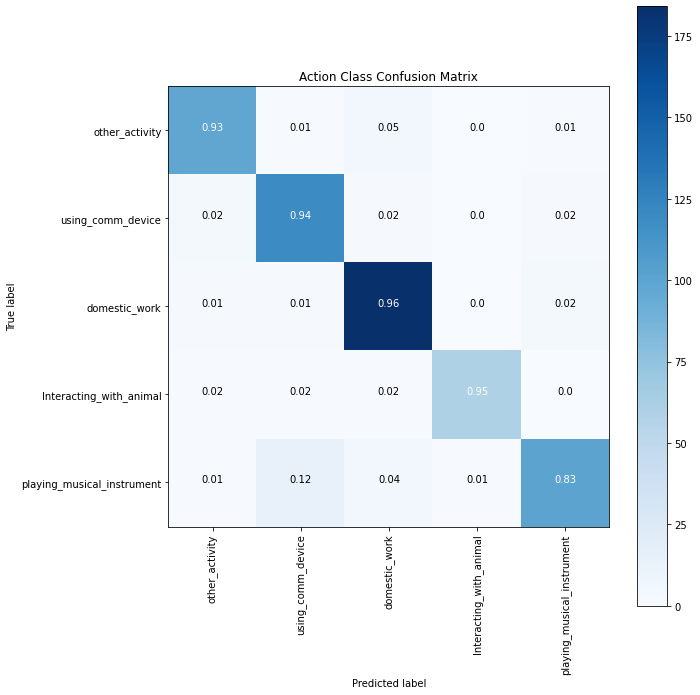

In [ ]:
# plot confusion matrix for action class
plot_confusion_matrix(cm_action_class, unique_action_class_list, title='Action Class Confusion Matrix')

## Classfication Report

In [ ]:
from sklearn.metrics import classification_report

print('\nAction Classification Report')
print(classification_report(true_action, test_y_action_label, target_names=unique_action_list))


Action Classification Report
                    precision    recall  f1-score   support

           jumping       1.00      0.85      0.92        27
           phoning       0.96      0.98      0.97        44
  using_a_computer       0.62      0.85      0.72        40
     rowing_a_boat       0.62      0.68      0.65        22
     riding_a_bike       0.97      0.90      0.94        40
           cooking       0.71      0.94      0.81        18
    riding_a_horse       0.68      0.84      0.75        32
    playing_guitar       0.60      0.60      0.60        30
   texting_message       0.91      0.97      0.94        32
    playing_violin       0.96      0.87      0.91        30
           running       0.98      0.98      0.98        44
cleaning_the_floor       0.89      0.89      0.89        28
       watching_TV       1.00      1.00      1.00        14
         gardening       0.77      0.72      0.74        32
          climbing       0.92      0.85      0.88        26
cutting_v

In [ ]:
print('\nAction Class Classification Report')
print(classification_report(true_action_class, test_y_action_class_label, target_names=unique_action_class_list))


Action Class Classification Report
                            precision    recall  f1-score   support

            other_activity       0.93      0.93      0.93       105
         using_comm_device       0.87      0.94      0.90       126
             domestic_work       0.93      0.96      0.95       192
   Interacting_with_animal       0.98      0.95      0.97        62
playing_musical_instrument       0.93      0.83      0.88       121

                  accuracy                           0.92       606
                 macro avg       0.93      0.92      0.93       606
              weighted avg       0.93      0.92      0.92       606



# Predictions

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255.)

testGen = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './Images/Images',
    x_col = "FileName",
    y_col = None,
    target_size = (224, 224),
    batch_size = 1,
    color_mode = 'rgb',
    class_mode = None,
    shuffle = False)

Found 2100 validated image filenames.


In [ ]:
testGen.reset()
y_action_pred, y_action_class_pred = model_imp.predict(testGen, verbose=1)

print(y_action_pred.shape, y_action_class_pred.shape)

2100/2100 [==============================] - 26s 12ms/step
(2100, 21) (2100, 5)


In [ ]:
names = test['FileName'].tolist()
action_label = [act_label[np.argmax(i)] for i in y_action_pred]
action_class_label = [act_class_label[np.argmax(i)] for i in y_action_class_pred]
print(type(names))
print(type(action_label))
print(type(action_class_label))

<class 'list'>
<class 'list'>
<class 'list'>


In [ ]:
# action list
unique_action_list = []
for x in action_label:  
  if x not in unique_action_list:
      unique_action_list.append(x)

print('No. of Actions: ',len(unique_action_list))

# action class list
unique_action_class_list = []
for x in action_class_label:  
  if x not in unique_action_class_list:
      unique_action_class_list.append(x)

print('No. of Action Classes: ',len(unique_action_class_list))

No. of Actions:  21
No. of Action Classes:  5


In [ ]:
data = {
   'FileName': names,
   'action': action_label,
   'action_class': action_class_label}

results = pd.DataFrame(data)
results.head()

FileName             action             action_class
0  Img_1005.jpg     riding_a_horse  Interacting_with_animal
1  Img_1012.jpg  shooting_an_arrow           other_activity
2  Img_1014.jpg    texting_message        using_comm_device
3  Img_1015.jpg  shooting_an_arrow           other_activity
4   Img_102.jpg    texting_message        using_comm_device

In [ ]:
results.to_csv('s3835352_predictions.csv', index=False)

# Visualising Predictions

In [ ]:
!cp /content/drive/MyDrive/'Colab Notebooks'/Assignment1/results.zip . # /content/drive/MyDrive/Colab Notebooks/Assignment1/Images.zip
!unzip -q -o results.zip
!rm results.zip

In [ ]:
predictions_files = pd.read_csv('./results/s3835352_predictions.csv')

predictions_files['act_num'] = predictions_files['action'].map(lab_act)
predictions_files['act_class_num'] = predictions_files['action_class'].map(lab_act_class)
predictions_files.head()

FileName             action  ... act_num  act_class_num
0  Img_1005.jpg     riding_a_horse  ...      11              0
1  Img_1012.jpg  shooting_an_arrow  ...      14              2
2  Img_1014.jpg    texting_message  ...      16              4
3  Img_1015.jpg  shooting_an_arrow  ...      14              2
4   Img_102.jpg    texting_message  ...      16              4

[5 rows x 5 columns]

In [ ]:
prediction_generator = DataGenerator(predictions_files, batch_size=32, data_mean=0., 
                                      data_std=255., n_action=21, n_class=5, 
                                      Augment=False, data_prefix='./results/Images/')

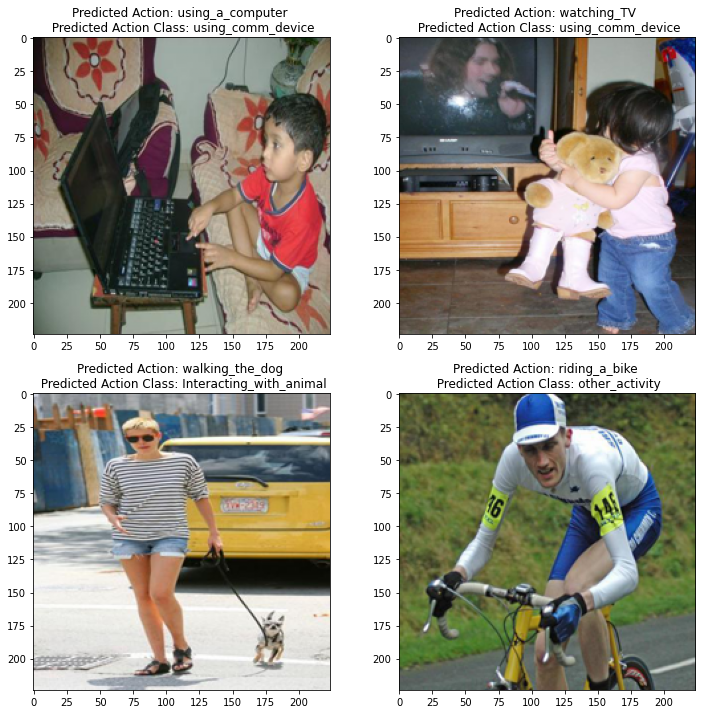

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0, 12):
  plt.subplot(2, 2, i+1)
  for x, y in prediction_generator:
    plt.imshow(x[i])
    plt.title('Predicted Action: {} \n Predicted Action Class: {}'.format(str(act_label[np.argmax(y['y_action'][i])]),
                                                                          str(act_class_label[np.argmax(y['y_action_class'][i])])))
    break
plt.tight_layout()
plt.show()